# Download and Test Plant Pathology Model
This notebook downloads the trained model from HuggingFace and tests it on the test dataset.

## Import Dependencies

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.models import efficientnet_b2
from PIL import Image
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from huggingface_hub import hf_hub_download
from safetensors.torch import load_file

c:\Users\Paula\Documents\programation\plant-pathology\venv9\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Constants

In [2]:
# Paths
DATA_DIR = Path('data/train')
TEST_DIR = Path('data/test')

# Model parameters
BATCH_SIZE = 32
IMG_SIZE = 260

# Device
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {DEVICE}')

# Class names
CLASS_NAMES = ['healthy', 'multiple_diseases', 'rust', 'scab']
NUM_CLASSES = len(CLASS_NAMES)

# HuggingFace model
REPO_ID = 'nahuelnb/plant-pathology-efficientnetb2'
MODEL_FILENAME = 'plant-pathology-efficientnetb2.safetensors'

TEST_SPLIT = 0.1

Using device: cuda


## Create the Test Set

In [3]:
import shutil
import random

if not TEST_DIR.exists():
    TEST_DIR.mkdir(parents=True, exist_ok=True)
    print(f'Created test directory: {TEST_DIR}')
    
    # Move 10% of images from each class to test set
    for class_name in CLASS_NAMES:
        train_class_dir = DATA_DIR / class_name
        test_class_dir = TEST_DIR / class_name
        test_class_dir.mkdir(parents=True, exist_ok=True)
        
        # Get all images in this class
        all_images = list(train_class_dir.glob('*.jpg'))
        
        # Calculate number of test images (10%)
        num_test = int(len(all_images) * TEST_SPLIT)
        
        # Randomly select images for test set
        random.seed(42)
        test_images = random.sample(all_images, num_test)
        
        # Move images from train to test
        for img_path in test_images:
            dest_path = test_class_dir / img_path.name
            shutil.move(str(img_path), str(dest_path))
        
        print(f'{class_name}: Moved {num_test} images to test set ({len(all_images)} total)')
    
    print(f'\nTest set created successfully!')
else:
    print(f'Test directory already exists: {TEST_DIR}')
    # Show test set statistics
    for class_name in CLASS_NAMES:
        test_class_dir = TEST_DIR / class_name
        if test_class_dir.exists():
            num_test_images = len(list(test_class_dir.glob('*.jpg')))
            print(f'{class_name}: {num_test_images} test images')

Test directory already exists: data\test
healthy: 51 test images
multiple_diseases: 9 test images
rust: 62 test images
scab: 59 test images


## Prepare Test Dataset

In [4]:
test_image_paths = []
test_labels = []

for class_idx, class_name in enumerate(CLASS_NAMES):
    class_dir = TEST_DIR / class_name
    for img_path in class_dir.glob('*.jpg'):
        test_image_paths.append(str(img_path))
        test_labels.append(class_idx)

print(f'Test images: {len(test_image_paths)}')
print(f'Class distribution:')
for class_idx, class_name in enumerate(CLASS_NAMES):
    count = test_labels.count(class_idx)
    print(f'  {class_name}: {count}')

Test images: 181
Class distribution:
  healthy: 51
  multiple_diseases: 9
  rust: 62
  scab: 59


In [5]:
class PlantPathologyDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_dataset = PlantPathologyDataset(test_image_paths, test_labels, test_transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f'Created test dataloader: {len(test_loader)} batches')

Created test dataloader: 6 batches


## Download Model from HuggingFace

In [6]:
print(f'Downloading model from {REPO_ID}...')
model_path = hf_hub_download(repo_id=REPO_ID, filename=MODEL_FILENAME)
print(f'Model downloaded to: {model_path}')

Model downloaded to: C:\Users\Paula\.cache\huggingface\hub\models--nahuelnb--plant-pathology-efficientnetb2\snapshots\f003db5e67317436f326ff66c66fc119f38f95be\plant-pathology-efficientnetb2.safetensors


c:\Users\Paula\Documents\programation\plant-pathology\venv9\lib\site-packages\huggingface_hub\file_download.py:130: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Paula\.cache\huggingface\hub\models--nahuelnb--plant-pathology-efficientnetb2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


## Load Model

In [7]:
class PlantPathologyModel(nn.Module):
    def __init__(self, num_classes=4):
        super(PlantPathologyModel, self).__init__()
        self.backbone = efficientnet_b2(pretrained=False)
        in_features = self.backbone.classifier[1].in_features
        self.backbone.classifier = nn.Sequential(
            nn.Dropout(p=0.3, inplace=True),
            nn.Linear(in_features, num_classes)
        )

    def forward(self, x):
        return self.backbone(x)

model = PlantPathologyModel(num_classes=NUM_CLASSES)

state_dict = load_file(model_path)
model.load_state_dict(state_dict)

model = model.to(DEVICE)
model.eval()

print('Model loaded successfully!')

Model loaded successfully!


## Test the Model

In [8]:
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc='Testing'):
        images = images.to(DEVICE)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

correct = sum([1 for pred, label in zip(all_preds, all_labels) if pred == label])
accuracy = 100 * correct / len(all_labels)
print(f'\nTest Accuracy: {accuracy:.2f}%')

Testing: 100%|██████████| 6/6 [00:12<00:00,  2.04s/it]


Test Accuracy: 96.69%


## Classification Report

In [9]:
print('\nClassification Report:')
print(classification_report(all_labels, all_preds, target_names=CLASS_NAMES))


Classification Report:
                   precision    recall  f1-score   support

          healthy       0.96      0.96      0.96        51
multiple_diseases       1.00      0.67      0.80         9
             rust       0.98      1.00      0.99        62
             scab       0.95      0.98      0.97        59

         accuracy                           0.97       181
        macro avg       0.97      0.90      0.93       181
     weighted avg       0.97      0.97      0.97       181



## Confusion Matrix

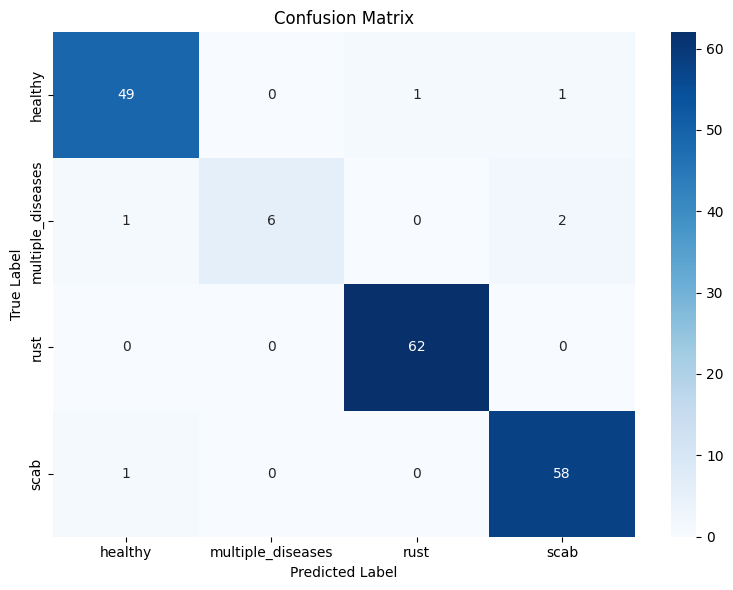

In [10]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

## Test on Individual Images

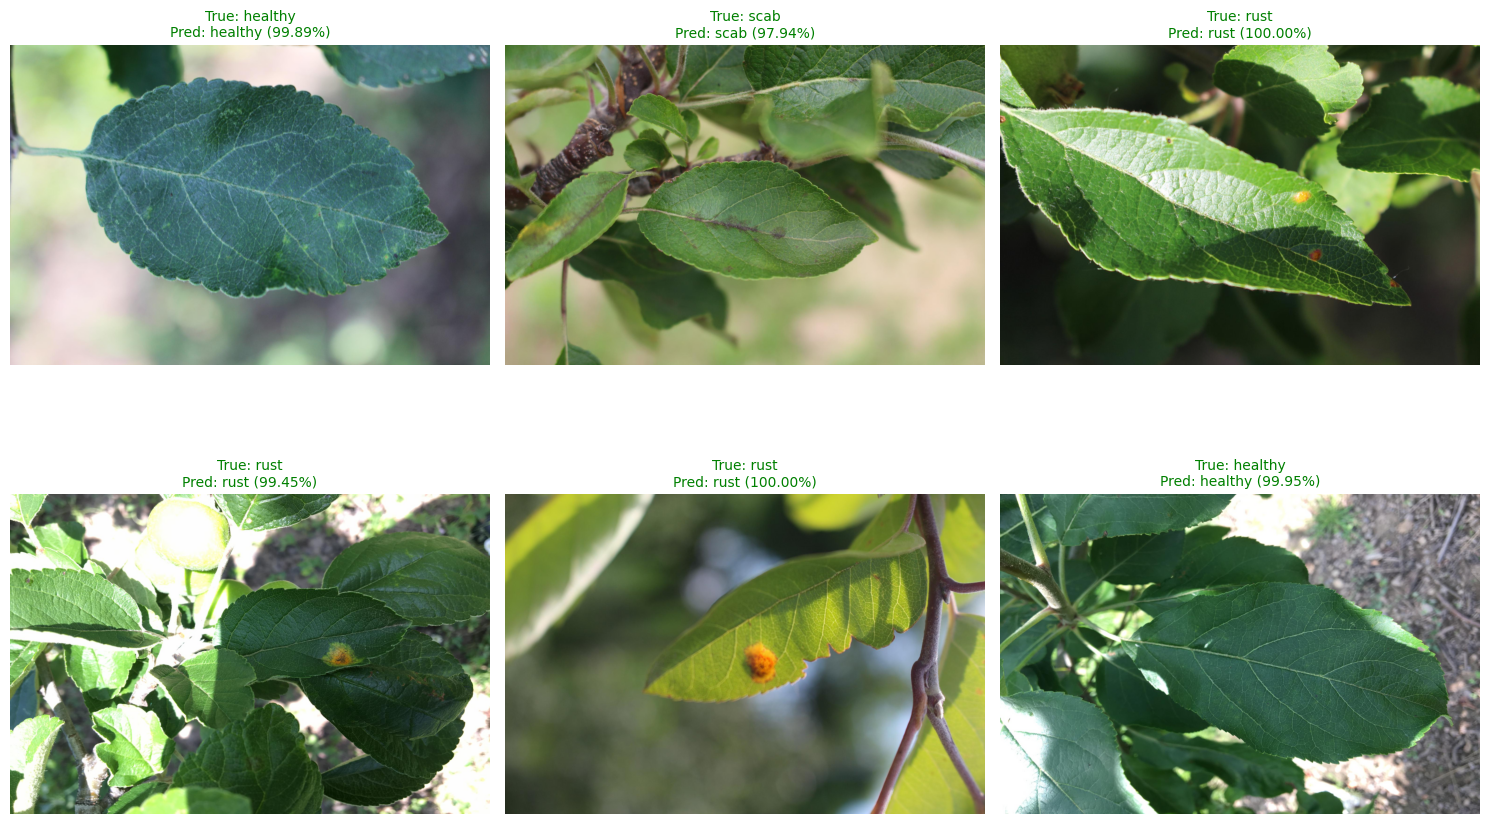

In [12]:
def predict_image(image_path, model, transform, device):
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(input_tensor)
        probabilities = torch.nn.functional.softmax(output[0], dim=0)
        predicted_class = torch.argmax(probabilities).item()
    
    return predicted_class, probabilities.cpu().numpy()

sample_indices = random.sample(range(len(test_image_paths)), min(6, len(test_image_paths)))

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for i, idx in enumerate(sample_indices):
    img_path = test_image_paths[idx]
    true_label = test_labels[idx]
    
    predicted_class, probabilities = predict_image(img_path, model, test_transform, DEVICE)
    
    # Display image
    image = Image.open(img_path)
    axes[i].imshow(image)
    axes[i].axis('off')
    
    # Add title with prediction
    title = f'True: {CLASS_NAMES[true_label]}\n'
    title += f'Pred: {CLASS_NAMES[predicted_class]} ({probabilities[predicted_class]:.2%})'
    color = 'green' if predicted_class == true_label else 'red'
    axes[i].set_title(title, color=color, fontsize=10)

plt.tight_layout()
plt.show()